In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1. use an existing GoEmotions model as a teacher that gives you p(e \mid x) for each emotion.

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

model_name = "SamLowe/roberta-base-go_emotions"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

def make_compute_valence(valence_map, tokenizer, model):
  def compute_valence(batch):
      # tokenize a batch of sentences
      enc = tokenizer(
          batch["text"],
          padding=True,
          truncation=True,
          return_tensors="pt"
      ).to(device)

      with torch.no_grad():
          logits = model(**enc).logits            # [batch, 28]
          probs = F.sigmoid(logits).cpu().numpy() # convert to numpy

      # compute valence for each example
      vals = []
      for example_prob in probs:
          v = 0.0
          for label, p in zip(model.config.id2label.values(), example_prob):
              v += p * valence_map[label]
          vals.append(v)

      batch["valence"] = vals
      return batch
  return compute_valence

2. build valence mapping table

In [ ]:
from typing import Dict

EMOTIONS = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse",
    "sadness", "surprise", "neutral"
]

admiration * 0.1 + anger *0.9 = annoyance * 0.4 + surprise *0.6

[-1,1] =


VALENCE_MAP: Dict[str, float] = {
    "admiration": 0.7,
    "amusement": 0.8,
    "anger": -0.8,
    "annoyance": -0.6,
    "approval": 0.5,
    "caring": 0.7,
    "confusion": -0.2,
    "curiosity": 0.2,
    "desire": 0.3,
    "disappointment": -0.7,
    "disapproval": -0.6,
    "disgust": -0.9,
    "embarrassment": -0.5,
    "excitement": 0.8,
    "fear": -0.9,
    "gratitude": 0.9,
    "grief": -1.0,
    "joy": 1.0,
    "love": 0.9,
    "nervousness": -0.7,
    "optimism": 0.6,
    "pride": 0.7,
    "realization": 0.1,
    "relief": 0.6,
    "remorse": -0.8,
    "sadness": -0.9,
    "surprise": 0.1,
    "neutral": 0.0,
}

3. use the GoEmotions text itself

In [ ]:
from datasets import load_dataset
ds = load_dataset("go_emotions", "simplified")  # or appropriate config
# Let's use train split for training, valid for eval
train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds = ds["test"]

4. Generate probabilistic valence labels using the roberta-base-go_emotions

In [ ]:
compute_valence = make_compute_valence(VALENCE_MAP, tokenizer, model)
train_with_val = train_ds.map(
    compute_valence,
    batched=True,
    batch_size=64
)

val_with_val = val_ds.map(
    compute_valence,
    batched=True,
    batch_size=64
)

test_with_val = test_ds.map(
    compute_valence,
    batched=True,
    batch_size=64
)

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, torch.nn.functional as F

model_name = "SamLowe/roberta-base-go_emotions"
tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

x = tok("halo", return_tensors="pt")
with torch.no_grad():
    logits = model(**x).logits
    probs = torch.sigmoid(logits)

print(probs)
print("sum =", probs.sum().item())

tensor([[5.3951e-03, 2.6556e-03, 1.9949e-03, 4.8961e-03, 1.6195e-02, 9.3770e-04,
         1.8681e-03, 1.0493e-03, 9.4835e-04, 3.1554e-03, 3.4571e-03, 1.9471e-03,
         7.4881e-04, 3.0417e-03, 1.6090e-03, 1.4963e-03, 5.0109e-04, 3.2242e-03,
         1.5563e-03, 4.0430e-04, 1.6846e-03, 5.3962e-04, 6.4084e-03, 5.1601e-04,
         3.6652e-04, 2.4512e-03, 1.1517e-03, 9.5974e-01]])
sum = 1.0299389362335205


5.  pick an MPNet encoder.

In [ ]:
from sentence_transformers import SentenceTransformer

mpnet = SentenceTransformer("all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
texts = train_with_val["text"]
val_texts = val_with_val["text"]
test_texts = test_with_val["text"]
embs_train = mpnet.encode(
    texts,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True,
    device="cuda"     # if GPU available
)
embs_val = mpnet.encode(
    val_texts,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True,
    device="cuda"     # if GPU available
)
embs_test = mpnet.encode(
    test_texts,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/1357 [00:00<?, ?it/s]

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

In [ ]:
y_train = train_with_val["valence"]
y_val   = val_with_val["valence"]
y_test  = test_with_val["valence"]

6. evaluation matrics

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
def evaluate_regression(y_true, y_pred):
    """
    Computes MAE, RMSE, R2, Pearson r, Spearman rho
    Returns a dictionary with all metrics.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    pearson_r, _ = pearsonr(y_true, y_pred)
    spearman_rho, _ = spearmanr(y_true, y_pred)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Pearson_r": pearson_r,
        "Spearman_rho": spearman_rho
    }
def print_metrics(name, metrics):
    print(f"\n=== {name} ===")
    print(f"MAE:          {metrics['MAE']:.3f}")
    print(f"RMSE:         {metrics['RMSE']:.3f}")
    print(f"R²:           {metrics['R2']:.3f}")
    print(f"Pearson r:    {metrics['Pearson_r']:.3f}")
    print(f"Spearman ρ:   {metrics['Spearman_rho']:.3f}")

7. Training

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(embs_train, y_train)
preds_ridge = ridge.predict(embs_val)

ridge_metrics = evaluate_regression(y_val, preds_ridge)
print_metrics("Ridge Regression", ridge_metrics)


=== Ridge Regression ===
MAE:          0.291
RMSE:         0.372
R²:           0.562
Pearson r:    0.750
Spearman ρ:   0.743


In [ ]:
from sklearn.isotonic import IsotonicRegression

# Stage 1: PLS
pls = PLSRegression(n_components=20)
pls.fit(embs_train, y_train)
pls_train_pred = pls.predict(embs_train).ravel()
pls_val_pred  = pls.predict(embs_val).ravel()

# Stage 2: Isotonic calibration
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(pls_train_pred, y_train)

preds_pls_iso = iso.predict(pls_val_pred)

pls_iso_metrics = evaluate_regression(y_val, preds_pls_iso)
print_metrics("PLS + Isotonic", pls_iso_metrics)


=== PLS + Isotonic ===
MAE:          0.286
RMSE:         0.370
R²:           0.568
Pearson r:    0.754
Spearman ρ:   0.743


In [ ]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=20)   # adjust 10–50 depending on dataset

pls.fit(embs_train, y_train)

preds_val = pls.predict(embs_val).ravel()  # flatten
metrics = evaluate_regression(y_val, preds_val)
print_metrics("PLS Regression (val)", metrics)


=== PLS Regression (val) ===
MAE:          0.291
RMSE:         0.373
R²:           0.561
Pearson r:    0.749
Spearman ρ:   0.743


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=25, metric="cosine")
knn.fit(embs_train, y_train)
preds_knn = knn.predict(embs_val)

knn_metrics = evaluate_regression(y_val, preds_knn)
print_metrics("Cosine k-NN (k=25)", knn_metrics)


=== Cosine k-NN (k=25) ===
MAE:          0.322
RMSE:         0.419
R²:           0.447
Pearson r:    0.673
Spearman ρ:   0.644


8. plot the result

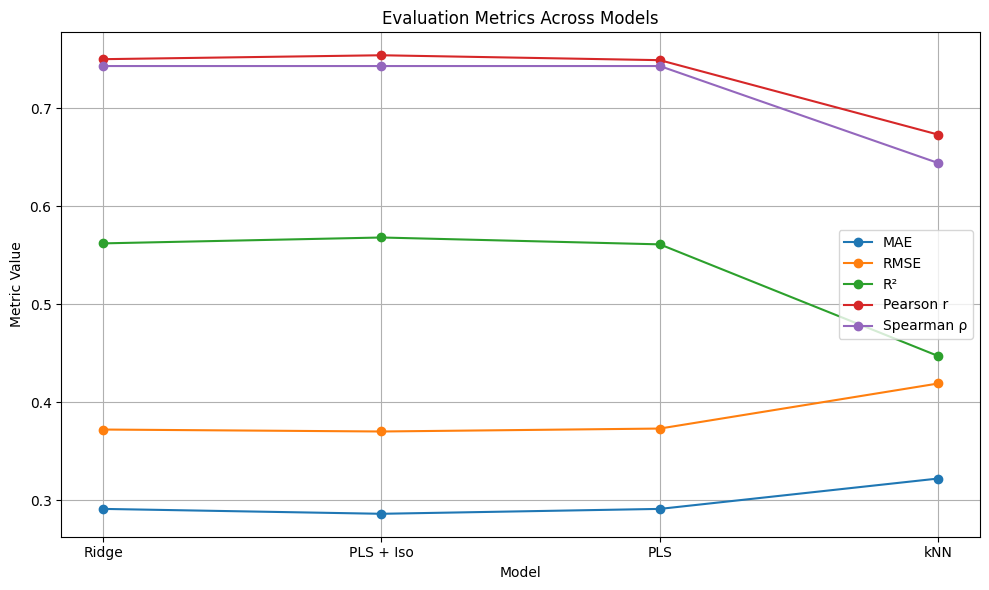

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results table
models = ["Ridge", "PLS + Iso", "PLS", "kNN"]
x = np.arange(len(models))

# Metric values
mae     = [0.291, 0.286, 0.291, 0.322]
rmse    = [0.372, 0.370, 0.373, 0.419]
r2      = [0.562, 0.568, 0.561, 0.447]
pearson = [0.750, 0.754, 0.749, 0.673]
spearman= [0.743, 0.743, 0.743, 0.644]

# Create plot
plt.figure(figsize=(10, 6))

plt.plot(x, mae, marker="o", label="MAE")
plt.plot(x, rmse, marker="o", label="RMSE")
plt.plot(x, r2, marker="o", label="R²")
plt.plot(x, pearson, marker="o", label="Pearson r")
plt.plot(x, spearman, marker="o", label="Spearman ρ")

plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

8. Testing

In [ ]:
test_pred_ridge = ridge.predict(embs_test)
test_pred_pls = pls.predict(embs_test).ravel()
test_pred_pls_iso = iso.predict(test_pred_pls)
test_pred_knn = knn.predict(embs_test)

In [ ]:
metrics_ridge = evaluate_regression(y_test, test_pred_ridge)
metrics_pls   = evaluate_regression(y_test, test_pred_pls)
metrics_iso   = evaluate_regression(y_test, test_pred_pls_iso)
metrics_knn   = evaluate_regression(y_test, test_pred_knn)

print_metrics("Ridge (test)", metrics_ridge)
print_metrics("PLS (test)", metrics_pls)
print_metrics("PLS + Iso (test)", metrics_iso)
print_metrics("kNN (test)", metrics_knn)


=== Ridge (test) ===
MAE:          0.282
RMSE:         0.360
R²:           0.589
Pearson r:    0.767
Spearman ρ:   0.759

=== PLS (test) ===
MAE:          0.282
RMSE:         0.360
R²:           0.588
Pearson r:    0.767
Spearman ρ:   0.759

=== PLS + Iso (test) ===
MAE:          0.277
RMSE:         0.357
R²:           0.597
Pearson r:    0.772
Spearman ρ:   0.759

=== kNN (test) ===
MAE:          0.312
RMSE:         0.408
R²:           0.472
Pearson r:    0.695
Spearman ρ:   0.662


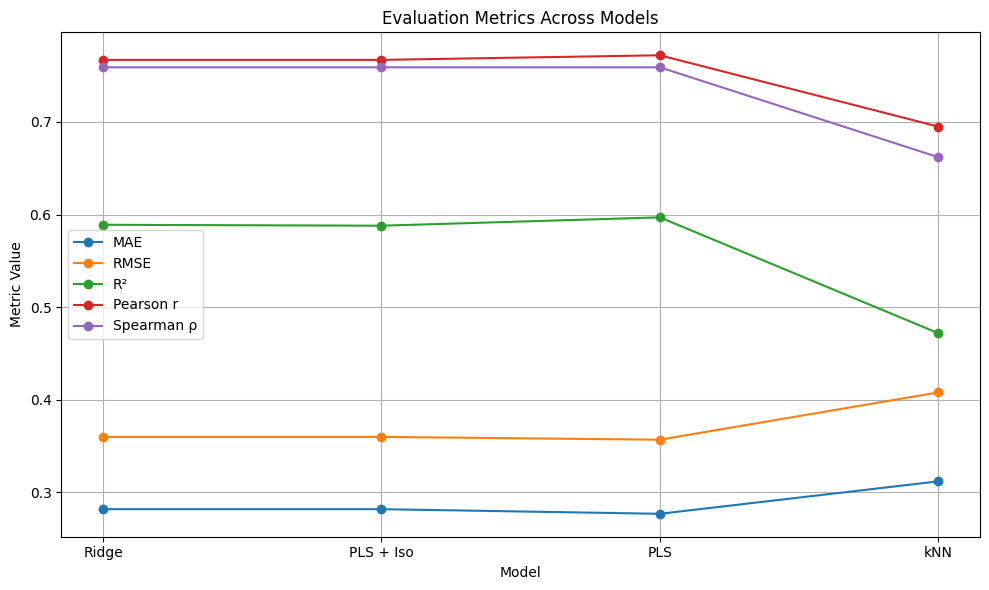

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results table
models = ["Ridge", "PLS + Iso", "PLS", "kNN"]
x = np.arange(len(models))

# Metric values
mae     = [0.282, 0.282, 0.277, 0.312]
rmse    = [0.360, 0.360, 0.357, 0.408]
r2      = [0.589, 0.588, 0.597, 0.472]
pearson = [0.767, 0.767, 0.772, 0.695]
spearman= [0.759, 0.759, 0.759, 0.662]

# Create plot
plt.figure(figsize=(10, 6))

plt.plot(x, mae, marker="o", label="MAE")
plt.plot(x, rmse, marker="o", label="RMSE")
plt.plot(x, r2, marker="o", label="R²")
plt.plot(x, pearson, marker="o", label="Pearson r")
plt.plot(x, spearman, marker="o", label="Spearman ρ")

plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
test_pred_pls_iso[0]

np.float64(0.32136734945045353)

same input,different output, higher accuracy:

it only proves which models is a better student of our labelling strategy.

So we still need external criteria(clinical expert's valence of the data) and compare our labelled valence to theirs.

If mine is better, then I can say my best models caon attain almost 1/3 of error rates when predicting the continuous value.